In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 美国小麦

In [5]:
wheat13 = pd.read_csv('./data/wheat-2013-supervised.csv')
wheat14 = pd.read_csv('./data/wheat-2014-supervised.csv')

In [6]:
wheat13.head()

,CountyName,State,Latitude,Longitude,Date,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,precipTypeIsOther,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield
0,Adams,Washington,46.811686,-118.695237,11/30/2013 0:00,35.70,20.85,0.00,29.53,0.91,...,0,1027.13,35.70,27.48,2.46,214,1.18,134.110657,0,35.7
1,Adams,Washington,46.929839,-118.352109,11/30/2013 0:00,35.10,26.92,0.00,29.77,0.93,...,0,1026.87,35.10,26.92,2.83,166,1.01,131.506592,0,35.7
2,Adams,Washington,47.006888,-118.510160,11/30/2013 0:00,33.38,26.95,0.00,29.36,0.94,...,0,1026.88,33.38,26.95,2.95,158,1.03,131.472946,0,35.7
3,Adams,Washington,47.162342,-118.699677,11/30/2013 0:00,28.05,25.93,0.91,29.47,0.94,...,0,1026.37,33.19,27.17,2.89,153,1.84,131.288300,0,35.7
4,Adams,Washington,47.157512,-118.434056,11/30/2013 0:00,28.83,25.98,0.91,29.86,0.94,...,0,1026.19,33.85,27.07,2.97,156,1.85,131.288300,0,35.7


## 数据情况

In [7]:
[wheat13.shape, wheat14.shape]

[(177493, 26), (182549, 26)]

In [8]:
wheat13.CountyName.value_counts()

Grant        3348
Garfield     3348
Ellis        3326
Clay         2232
Lincoln      2232
             ... 
Delaware      186
Coal          186
Jim Wells     186
Johnston       25
Lamar           7
Name: CountyName, Length: 150, dtype: int64

In [15]:
wheat13.isnull().sum()

CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             1
precipIntensityMax          1
precipProbability           1
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  254
temperatureMax              0
temperatureMin              0
visibility                 30
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

In [16]:
wheat14.isnull().sum()

CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             0
precipIntensityMax          0
precipProbability           0
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  351
temperatureMax              0
temperatureMin              0
visibility                 16
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

## 处理缺失值

In [9]:
def impute_with_nearest(in_df,in_column):
    """
    将缺失值填充为同一天位置最近的值
    """
    # 缺失值位置  
    df_nan = in_df[in_df[in_column].isnull()]
    if len(df_nan) > 0:
        # 找同一天，位置相近
        for i in range(len(df_nan)):
            tmp_date = df_nan['Date'].iloc[i]
            tmp_long = df_nan['Longitude'].iloc[i]
            tmp_lat  = df_nan['Latitude'].iloc[i]
            tmp_index = df_nan['Latitude'].index.tolist()[i]
            condition = (((in_df['Latitude'] != tmp_lat) |
                         (in_df['Longitude'] != tmp_long)) & 
                         (in_df['Date'] == tmp_date) & 
                         (in_df[in_column].notnull())) 
            # 按距离排序
            new_df = in_df[['Longitude', 'Latitude']][condition]
            new_df['Distance'] = new_df['Longitude']
            for j in range(len(new_df)):
                new_df['Distance'].iloc[j] = haversine(tmp_long,
                                                       tmp_lat,
                                                       new_df['Longitude'].iloc[j],
                                                       new_df['Latitude'].iloc[j])
            # 选取同一天的最近位置
            tmp_df = new_df.sort_values(by='Distance', ascending=True)
            tmp_min_dist = tmp_df.iloc[0,2]
            tmp_min_index = tmp_df.index.tolist()[0]
            # 替换缺失值
            old_val = in_df[in_column].iloc[tmp_index]
            new_val = in_df[in_column].iloc[tmp_min_index]
            in_df[in_column].iloc[tmp_index] = new_val

In [10]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    经纬度转换为地理距离，球坐标系下转换
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2. * asin(sqrt(a)) 
    r = 6371.
    return c * r

In [11]:
# 字符串日期转换为Datetime格式
now = time.time()
if not wheat13['Date'].dtype == np.dtype('datetime64[ns]'):
    wheat13['Date'] = wheat13['Date'].apply(pd.to_datetime)
print('Exec. time: {:5.2f} s'.format(time.time()-now))

now = time.time()
if not wheat14['Date'].dtype == np.dtype('datetime64[ns]'):
    wheat14['Date'] = wheat14['Date'].apply(pd.to_datetime)
print('Exec. time: {:5.2f} s'.format(time.time()-now))

Exec. time: 49.65 s
Exec. time: 57.87 s


In [12]:
now = time.time()
impute_with_nearest(wheat13, 'precipIntensity')
impute_with_nearest(wheat13, 'precipIntensityMax')
impute_with_nearest(wheat13, 'precipProbability')
impute_with_nearest(wheat13, 'pressure')
impute_with_nearest(wheat13, 'visibility')
print('Exec. time: {:5.2f} s'.format(time.time()-now))

now = time.time()
impute_with_nearest(wheat14, 'pressure')
impute_with_nearest(wheat14, 'visibility')
print('Exec. time: {:5.2f} s'.format(time.time()-now))

/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Exec. time: 52.76 s
Exec. time: 67.00 s


In [13]:
print(wheat13.isnull().sum().sum())
print(wheat14.isnull().sum().sum())

0
0


In [14]:
def save_data():
    wheat13.to_pickle('./data/wheat13.df')
    wheat14.to_pickle('./data/wheat14.df')
save_data()

## 【周报6】降水量

In [6]:
wheat13['Location'] = list(zip(wheat13['Longitude'], wheat13['Latitude']))
wheat14['Location'] = list(zip(wheat14['Longitude'], wheat14['Latitude']))

In [7]:
# 计算总降水量
wheat13['precipTotal'] = wheat13.groupby(by='Location')['precipAccumulation'].apply(lambda x: x.cumsum())
wheat14['precipTotal'] = wheat14.groupby(by='Location')['precipAccumulation'].apply(lambda x: x.cumsum())

In [10]:
locations = wheat13['Location'].unique()
for idx,loc in enumerate(locations):
    if idx < 5:
        tmp1 = wheat13['precipAccumulation'][wheat13['Location'] == loc].sum()
        tmp2 = wheat13['precipTotal'][wheat13['Location'] == loc].max()
        print(loc, tmp1, tmp2)

(-118.6952372, 46.81168579999999) 9.982 9.982
(-118.35210929999998, 46.9298391) 12.312000000000001 12.312000000000001
(-118.5101603, 47.0068881) 13.75 13.75
(-118.6996774, 47.1623419) 12.934 12.934000000000001
(-118.43405590000002, 47.157512) 16.644 16.644000000000002


In [17]:
# 降水与产量的相关性
wheat13.groupby(by='Location').agg({'precipTotal': np.max, 'Yield': np.max}).corr()

,precipTotal,Yield
precipTotal,1.000000,0.098991
Yield,0.098991,1.000000


In [13]:
# 按县聚合数据后再计算相关性
wheat13.groupby(by='CountyName').agg({'precipTotal': np.mean, 'Yield': np.max}).corr()

,precipTotal,Yield
precipTotal,1.0000,0.1178
Yield,0.1178,1.0000


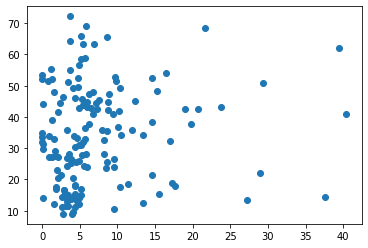

In [16]:
tmp = wheat13.groupby(by='CountyName').agg({'precipTotal': np.mean, 'Yield': np.max})
x = tmp['precipTotal'].values
y = tmp['Yield'].values

plt.scatter(x,y)

## 两年数据的一致性

In [3]:
wheat13 = pd.read_pickle('./data/wheat13.df')
wheat14 = pd.read_pickle('./data/wheat14.df')

In [17]:
# 观察两年数据中的部分差别
features = wheat13.columns
for feature in features:
    n_unique_2013 = len(wheat13[feature].unique())
    n_unique_2014 = len(wheat14[feature].unique())
    print('{:25} : {:6.0f} {:6.0f}'.format(feature,n_unique_2013,n_unique_2014))
print('---------------------')
print('Total number of observations (2013) : {}'.format(wheat13.shape[0]))
print('Total number of observations (2014) : {}'.format(wheat14.shape[0]))

CountyName                :    150    156
State                     :      5      5
Latitude                  :   1014   1035
Longitude                 :   1014   1035
Date                      :    186    186
apparentTemperatureMax    :  11290   9941
apparentTemperatureMin    :  10916   9960
cloudCover                :    101    101
dewPoint                  :   8909   8331
humidity                  :     93     86
precipIntensity           :    661    815
precipIntensityMax        :   3131   4184
precipProbability         :     97     98
precipAccumulation        :   2761   1911
precipTypeIsRain          :      2      2
precipTypeIsSnow          :      2      2
precipTypeIsOther         :      1      1
pressure                  :   5116   4655
temperatureMax            :  10408   8323
temperatureMin            :   9329   8494
visibility                :    876    899
windBearing               :    360    360
windSpeed                 :   2694   2341
NDVI                      : 125108

* 14年的数据中出现了13年没有记录的县，要在后续的处理中加以区分

## 部分县有多个产量数据

In [39]:
gb = wheat13.groupby(by='CountyName')
gb_agg = gb.agg(Count=('Yield', lambda x: len(x.unique())))
diff_counties_2013 = gb_agg[gb_agg.Count > 1].index.values
gb_agg[gb_agg.Count > 1]

,Count
CountyName,
Blaine,2.0
Brown,2.0
Clay,2.0
Comanche,2.0
Custer,2.0
Douglas,2.0
Ellis,3.0
Franklin,2.0
Garfield,3.0


In [40]:
gb = wheat14.groupby(by='CountyName')
gb_agg = gb.agg(Count=('Yield', lambda x: len(x.unique())))
diff_counties_2014 = gb_agg[gb_agg.Count > 1].index.values
gb_agg[gb_agg.Count > 1]

,Count
CountyName,
Blaine,2.0
Brown,2.0
Carter,2.0
Comanche,3.0
Douglas,2.0
Ellis,3.0
Franklin,2.0
Grant,3.0
Hamilton,2.0


In [42]:
# 有多个产量的县都来自哪些州
print('I count {} counties in 2013 with more than one yield level.'.format(len(diff_counties_2013)))
for idx, diff_county in enumerate(diff_counties_2013):
    print('{:10} {}'.format(diff_county, wheat13['State'][wheat13['CountyName'] == diff_county].unique()))

I count 19 counties in 2013 with more than one yield level.
Blaine     ['Montana' 'Oklahoma']
Brown      ['Kansas' 'Texas']
Clay       ['Kansas' 'Texas']
Comanche   ['Kansas' 'Oklahoma']
Custer     ['Montana' 'Oklahoma']
Douglas    ['Kansas' 'Washington']
Ellis      ['Kansas' 'Oklahoma' 'Texas']
Franklin   ['Kansas' 'Washington']
Garfield   ['Montana' 'Oklahoma' 'Washington']
Grant      ['Kansas' 'Oklahoma' 'Washington']
Gray       ['Kansas' 'Texas']
Hamilton   ['Kansas' 'Texas']
Harper     ['Kansas' 'Oklahoma']
Hill       ['Montana' 'Texas']
Jackson    ['Kansas' 'Oklahoma']
Johnson    ['Kansas' 'Texas']
Lincoln    ['Kansas' 'Washington']
Logan      ['Kansas' 'Oklahoma']
Marshall   ['Kansas' 'Oklahoma']


In [45]:
print('I count {} counties in 2014 with more than one yield level.'.format(len(diff_counties_2014)))
for idx, diff_county in enumerate(diff_counties_2014):
    print('{:10} {}'.format(diff_county, wheat14['State'][wheat14['CountyName'] == diff_county].unique()))

I count 14 counties in 2014 with more than one yield level.
Blaine     ['Montana' 'Oklahoma']
Brown      ['Kansas' 'Texas']
Carter     ['Montana' 'Oklahoma']
Comanche   ['Kansas' 'Oklahoma' 'Texas']
Douglas    ['Kansas' 'Washington']
Ellis      ['Kansas' 'Oklahoma' 'Texas']
Franklin   ['Kansas' 'Washington']
Grant      ['Kansas' 'Oklahoma' 'Washington']
Hamilton   ['Kansas' 'Texas']
Harper     ['Kansas' 'Oklahoma']
Hill       ['Montana' 'Texas']
Jackson    ['Kansas' 'Oklahoma']
Jefferson  ['Kansas' 'Oklahoma']
Lincoln    ['Oklahoma' 'Washington']


在不同都州，有同名的县，导致了某个县可能有多个产量的值

但是重名的情况在2013年和2014年又有所不同，有的重名的县并未在另一年里出现多个产量值

可能有两个原因：

    1. 不同州的两个县刚好产量相同
    2. 这个县在这一年并没有被其中一个州统计到

In [51]:
for idx, diff_county in enumerate(diff_counties_2013):
    tmp_states = wheat14['State'][wheat14['CountyName'] == diff_county].unique()
    tmp_yields = np.zeros(len(tmp_states))
    for ix,tmp_state in enumerate(tmp_states):
        tmp_yields[ix] = wheat14['Yield'][(wheat14['CountyName'] == diff_county) & 
                                          (wheat14['State'] == tmp_state)].unique()

    print(diff_county, tmp_states, tmp_yields)

County 2013 State 2014                          Yield 2014
----------------------------------------------------------------
Blaine ['Montana' 'Oklahoma'] [32.4 26.6]
Brown ['Kansas' 'Texas'] [42.  21.4]
Clay ['Texas'] [25.2]
Comanche ['Kansas' 'Oklahoma' 'Texas'] [41.5 20.9 30.3]
Custer ['Oklahoma'] [30.3]
Douglas ['Kansas' 'Washington'] [30.9 37.8]
Ellis ['Kansas' 'Oklahoma' 'Texas'] [32.9 22.4 39.3]
Franklin ['Kansas' 'Washington'] [39.9 30. ]
Garfield ['Oklahoma'] [27.3]
Grant ['Kansas' 'Oklahoma' 'Washington'] [33.5 23.6 41.7]
Gray ['Kansas'] [46.6]
Hamilton ['Kansas' 'Texas'] [20.5 26.1]
Harper ['Kansas' 'Oklahoma'] [27.7 27.5]
Hill ['Montana' 'Texas'] [28.2 43. ]
Jackson ['Kansas' 'Oklahoma'] [32.9 25.2]
Johnson ['Texas'] [33.9]
Lincoln ['Oklahoma' 'Washington'] [34.9 53. ]
Logan ['Oklahoma'] [31.6]
Marshall [] []


In [53]:
for idx, diff_county in enumerate(diff_counties_2014):
    tmp_states = wheat13['State'][wheat13['CountyName'] == diff_county].unique()
    tmp_yields = np.zeros(len(tmp_states))
    for ix,tmp_state in enumerate(tmp_states):
        tmp_yields[ix] = wheat13['Yield'][(wheat13['CountyName'] == diff_county) & 
                                          (wheat13['State'] == tmp_state)].unique()
    print(diff_county, tmp_states, tmp_yields)

Blaine ['Montana' 'Oklahoma'] [38.4 18.1]
Brown ['Kansas' 'Texas'] [51.2 13.6]
Carter ['Montana'] [40.9]
Comanche ['Kansas' 'Oklahoma'] [14.5 15.3]
Douglas ['Kansas' 'Washington'] [44.8 35.3]
Ellis ['Kansas' 'Oklahoma' 'Texas'] [19.9 10.2 54.9]
Franklin ['Kansas' 'Washington'] [47.4 31.3]
Grant ['Kansas' 'Oklahoma' 'Washington'] [27.7 12.7 42.9]
Hamilton ['Kansas' 'Texas'] [12.1 27. ]
Harper ['Kansas' 'Oklahoma'] [12.6 10.3]
Hill ['Montana' 'Texas'] [38.8 49.4]
Jackson ['Kansas' 'Oklahoma'] [45.4 11.8]
Jefferson ['Oklahoma'] [20.6]
Lincoln ['Kansas' 'Washington'] [23.3 48. ]


这些县是不是不同的县，还要通过经纬度来确定

In [54]:
wheat13['Location'] = list(zip(wheat13['Longitude'], wheat13['Latitude']))
wheat14['Location'] = list(zip(wheat14['Longitude'], wheat14['Latitude']))

In [77]:
wheat13[wheat13.CountyName=='Blaine']

,CountyName,State,Latitude,Longitude,Date,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield,Location
102,Blaine,Montana,48.212217,-108.882204,2013-11-30,44.41,25.51,0.38,31.02,0.79,...,1019.37,44.41,32.84,9.76,220,3.63,134.522751,0,38.4,"(-108.8822041, 48.21221729999999)"
103,Blaine,Montana,48.081676,-108.725491,2013-11-30,44.22,25.35,0.38,30.83,0.79,...,1019.46,44.22,32.68,9.79,219,3.44,134.522751,0,38.4,"(-108.72549099999999, 48.081676200000004)"
104,Blaine,Montana,48.481187,-109.150552,2013-11-30,42.73,27.39,0.38,32.03,0.79,...,1018.74,46.22,33.98,9.62,226,5.46,134.120834,0,38.4,"(-109.15055179999999, 48.4811875)"
105,Blaine,Montana,48.286431,-108.890097,2013-11-30,42.78,26.73,0.38,31.50,0.80,...,1019.18,44.72,33.60,9.74,217,3.80,133.543808,0,38.4,"(-108.89009679999998, 48.2864305)"
106,Blaine,Montana,48.254877,-108.969878,2013-11-30,42.79,26.79,0.38,31.52,0.80,...,1019.15,44.82,33.64,9.74,217,3.89,133.543808,0,38.4,"(-108.96987779999999, 48.2548771)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176651,Blaine,Oklahoma,35.861890,-98.390412,2014-06-03,94.89,70.16,0.09,68.63,0.67,...,1011.79,90.96,70.16,10.00,171,12.79,158.766846,185,18.1,"(-98.39041170000002, 35.861889500000004)"
176652,Blaine,Oklahoma,35.864496,-98.237745,2014-06-03,94.50,70.63,0.09,68.67,0.68,...,1011.80,90.86,70.63,9.99,172,13.41,158.667541,185,18.1,"(-98.23774470000001, 35.864496100000004)"
176653,Blaine,Oklahoma,35.764211,-98.406222,2014-06-03,94.43,70.45,0.09,68.37,0.67,...,1011.81,90.90,70.45,10.00,172,13.15,158.344482,185,18.1,"(-98.4062218, 35.764210799999994)"
176654,Blaine,Oklahoma,36.161533,-98.281136,2014-06-03,95.54,69.34,0.11,69.04,0.69,...,1011.55,91.66,69.34,9.90,172,13.93,156.537994,185,18.1,"(-98.2811363, 36.161533399999996)"


可以看出，确实是不同州存在同名的县

## 相关性

In [4]:
# 找出所有的相关性超过0.65的列
X = wheat13.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1

In [5]:
newDF.sort_values(by='corr', ascending=False)

,col1,col2,corr,corr col1 with target,corr col2 with target
7,apparentTemperatureMin,temperatureMin,0.992737,-0.049998,-0.060512
2,apparentTemperatureMax,temperatureMax,0.991843,-0.140315,-0.152702
12,precipIntensity,precipIntensityMax,0.912594,0.046476,0.030030
11,dewPoint,temperatureMin,0.910333,0.011607,-0.060512
5,apparentTemperatureMin,dewPoint,0.909563,-0.049998,0.011607
6,apparentTemperatureMin,temperatureMax,0.893452,-0.049998,-0.152702
0,apparentTemperatureMax,apparentTemperatureMin,0.888862,-0.140315,-0.049998
14,temperatureMax,temperatureMin,0.886946,-0.152702,-0.060512
3,apparentTemperatureMax,temperatureMin,0.880383,-0.140315,-0.060512
1,apparentTemperatureMax,dewPoint,0.796342,-0.140315,0.011607


In [6]:
# 找出所有的相关性超过0.65的列
X = wheat14.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1

In [7]:
newDF.sort_values(by='corr', ascending=False)

,col1,col2,corr,corr col1 with target,corr col2 with target
2,apparentTemperatureMax,temperatureMax,0.993237,-0.165742,-0.172160
7,apparentTemperatureMin,temperatureMin,0.992886,-0.146381,-0.153430
9,dewPoint,temperatureMin,0.951772,-0.158787,-0.153430
5,apparentTemperatureMin,dewPoint,0.949988,-0.146381,-0.158787
10,precipIntensity,precipIntensityMax,0.863038,-0.015459,-0.020094
0,apparentTemperatureMax,apparentTemperatureMin,0.849104,-0.165742,-0.146381
6,apparentTemperatureMin,temperatureMax,0.844614,-0.146381,-0.172160
3,apparentTemperatureMax,temperatureMin,0.841444,-0.165742,-0.153430
13,temperatureMax,temperatureMin,0.838178,-0.172160,-0.153430
1,apparentTemperatureMax,dewPoint,0.796485,-0.165742,-0.158787


有些特征表现出强相关，如温度相关的属性

### 删除相关性过高的列

删掉一些相关性过高的列，因为其包含的信息在其他的列中已经有所体现

In [9]:
wheat13.drop('precipTypeIsOther', axis=1, inplace=True)
wheat13.drop('apparentTemperatureMin', axis=1, inplace=True)
wheat13.drop('apparentTemperatureMax', axis=1, inplace=True)
wheat13.drop('precipIntensityMax', axis=1, inplace=True)
#
wheat14.drop('precipTypeIsOther', axis=1, inplace=True)
wheat14.drop('apparentTemperatureMin', axis=1, inplace=True)
wheat14.drop('apparentTemperatureMax', axis=1, inplace=True)
wheat14.drop('precipIntensityMax', axis=1, inplace=True)

In [ ]:
wheat13.to_pickle(os.path.join('data','wheat13_clean.df'))
wheat14.to_pickle(os.path.join('data','wheat14_clean.df'))

## 【周报7】地图可视化

In [25]:
# read data 
df_2013 = pd.read_pickle('./data/df_2013_clean.df')
df_2014 = pd.read_pickle('./data/df_2014_clean.df')

In [4]:
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

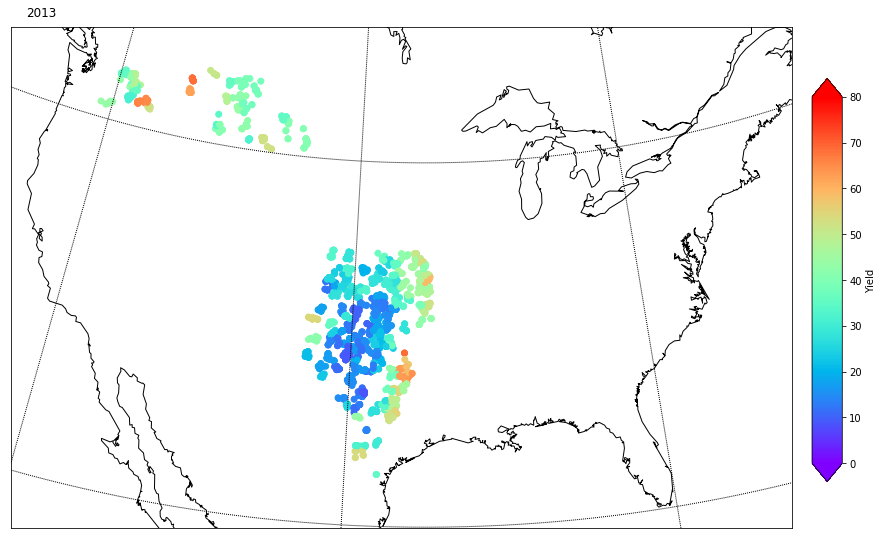

In [7]:
fig, ax = plt.subplots(figsize=(14, 14))

redraw = True
if redraw:
    mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
                    urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                    lon_0=-95, area_thresh=10000,
                    resolution = 'l',)
    pickle.dump(mymap,open('mymap.pickle','wb'),-1)  # pickle it 
else:
    pickle.load(open('mymap.pickle','rb'))


lng = np.array(df_2013[['Longitude']].iloc[::100,:])
lat = np.array(df_2013[['Latitude']].iloc[::100,:])
yld = np.array(df_2013[['Yield']].iloc[::100,:])
x,y = mymap(lng, lat)

im1 = mymap.scatter(x, y, c=yld, vmin=0, vmax=80, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax.annotate('2013', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

cax1 = fig.add_axes([0.92, 0.3, 0.03, 0.4])
cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label('Yield')


可以看出，这个数据集主要来自两个大大区域，在下面的这个区域中，在偏东的产量要高一些

## 删掉预测无关的列

In [26]:
drop_vec = ['CountyName', 'State', 'Date', 'Location']
for drop_col in drop_vec:
    if drop_col in df_2013.columns:
        df_2013.drop(drop_col, axis=1, inplace=True)
    if drop_col in df_2014.columns:
        df_2014.drop(drop_col, axis=1, inplace=True)

## 散布矩阵

In [9]:
# 抽100点作散布矩阵
df_tmp = df_2013.sample(n=100)

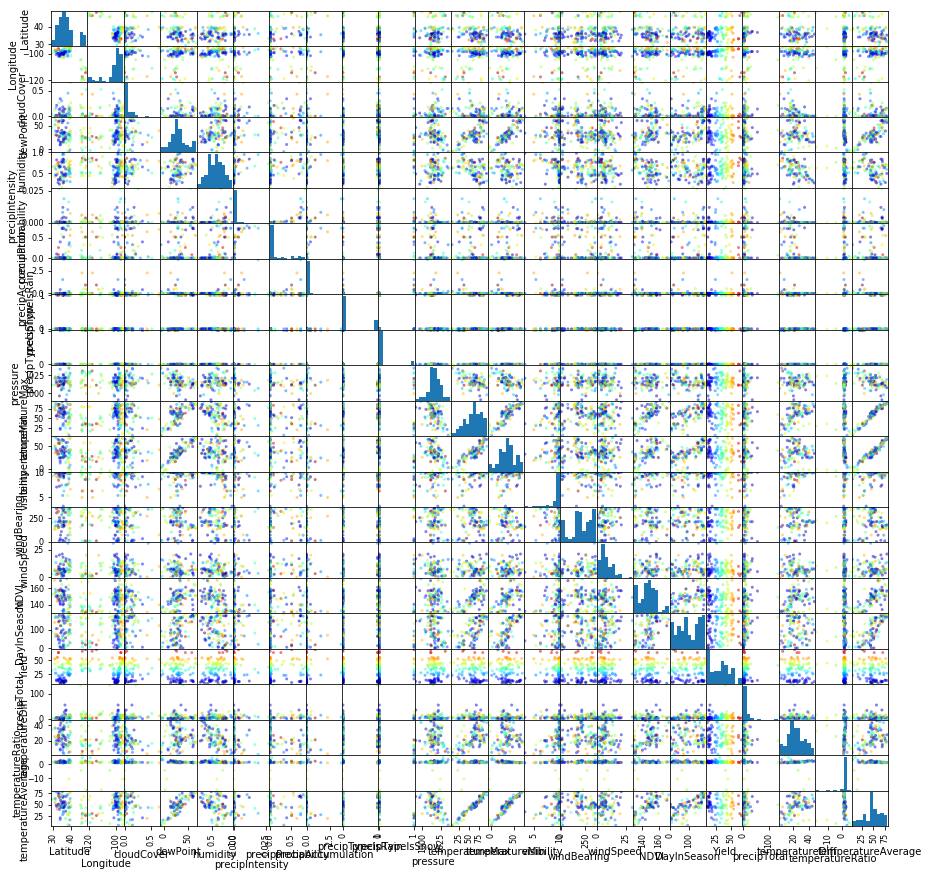

In [11]:
import matplotlib.cm as cm
pd.plotting.scatter_matrix(df_tmp, diagonal='hist', figsize=(15, 15), c=df_tmp["Yield"].tolist(), cmap=cm.get_cmap('jet'));

通过之前的相关性矩阵和上面分布矩阵，可以看出一些数据特征之间有显著的多重共线性

共线性会导致难以分清哪些指标与产量的关系最为强烈，但是对于预测产量来说，共线性的数据也能用，在预测的时候可以使用正规化的手段来减轻共享性特征的影响

## 训练-测试集划分

In [27]:
from sklearn.model_selection import train_test_split
y = df_2013['Yield']
X = df_2013.drop('Yield', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 数值标准化

In [28]:
from sklearn import preprocessing
columns_to_scale = ['Latitude',
    'Longitude',
    'cloudCover',
    'dewPoint',
    'humidity',
    'precipIntensity',
    'precipProbability',
    'precipAccumulation',
#     'precipTypeIsRain,
#     'precipTypeIsSnow,
    'pressure',
    'temperatureMax',
    'temperatureMin',
    'visibility',
    'windBearing',
    'windSpeed',
    'NDVI',
    'DayInSeason',]

std_scaler = preprocessing.StandardScaler().fit(X_train[columns_to_scale])
X_train[columns_to_scale] = std_scaler.transform(X_train[columns_to_scale])


/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [29]:
X_test[columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])

/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


## 回归模型

In [30]:
# sklean 参数设置
from sklearn.model_selection import cross_val_score
cv_k = 5
cv_scoring = 'neg_mean_squared_error'

In [31]:
# 数据是按照县分好了组，并且是按照时间顺序排列对，先对数据进行混洗
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv_k, shuffle=True)

In [32]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

### 线性回归

In [43]:
X_train.describe()

,Latitude,Longitude,cloudCover,dewPoint,humidity,precipIntensity,precipProbability,precipAccumulation,precipTypeIsRain,precipTypeIsSnow,...,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,precipTotal,temperatureDiff,temperatureRatio,temperatureAverage
count,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,141994.000000,141994.000000,...,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,1.419940e+05,141994.000000,141994.000000,1.419940e+05,141994.000000
mean,2.030061e-15,-3.190472e-15,-1.111396e-16,-3.187820e-16,5.376834e-16,4.508634e-17,1.471936e-16,-1.513720e-17,0.209840,0.090060,...,-3.913154e-17,1.083073e-15,2.504519e-17,-1.136416e-16,4.187325e-15,-3.102501e-18,7.528621,23.168858,inf,45.952304
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.407196,0.286269,...,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,9.737616,9.601040,NaN,18.752358
min,-1.978326e+00,-3.364810e+00,-5.132253e-01,-3.938440e+00,-3.142469e+00,-2.548018e-01,-5.260770e-01,-1.581210e-01,0.000000,0.000000,...,-4.160628e+00,-6.767845e+00,-1.836741e+00,-1.758991e+00,-2.894448e+00,-1.726562e+00,0.000000,1.100000,-1.877500e+03,-30.500000
25%,-6.830320e-01,-6.713608e-02,-5.132253e-01,-6.052665e-01,-7.585528e-01,-2.548018e-01,-5.260770e-01,-1.581210e-01,0.000000,0.000000,...,-6.147917e-01,-8.227231e-02,-6.156756e-01,-7.720782e-01,-8.371155e-01,-8.685343e-01,2.053000,16.070000,1.403035e+00,33.520000
50%,-1.452861e-01,2.926597e-01,-4.411609e-01,-1.113965e-01,3.608614e-02,-2.548018e-01,-5.260770e-01,-1.581210e-01,0.000000,0.000000,...,-6.440157e-02,4.709627e-01,-3.355126e-04,-1.602345e-01,8.537308e-02,8.145825e-03,4.731000,22.730000,1.646320e+00,46.140000
75%,2.893014e-01,5.908138e-01,1.353550e-01,5.512873e-01,7.695990e-01,-2.107984e-01,-1.709031e-01,-1.581210e-01,0.000000,0.000000,...,6.548646e-01,5.566752e-01,7.976836e-01,6.464774e-01,6.517776e-01,8.661732e-01,8.608000,29.990000,2.034133e+00,59.275000
max,2.331687e+00,1.050552e+00,6.693223e+00,2.679418e+00,2.481129e+00,3.078954e+01,3.222980e+00,5.325275e+01,1.000000,1.000000,...,2.330721e+00,5.566752e-01,1.614932e+00,4.879095e+00,5.882518e+00,1.724201e+00,135.177000,78.960000,inf,87.830000


In [33]:
now = time.time()
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: nan (+/- nan)
Exec. time:  0.13 s


/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
/Users/jinkinhuang/Projects/bishe/bishe-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value 